In [1]:
import pandas as pd
import datetime as datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv('monero_price.csv', index_col=False)

In [3]:
df = pd.read_csv('monero_price.csv', index_col=False)
df.drop(['Market Cap'], axis='columns', inplace=True)
df['Date'] = df['Date'].astype('datetime64[ns]')
df = df.set_index(pd.DatetimeIndex(df['Date']))
df.drop('Date', axis='columns', inplace=True)

In [4]:
df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1371 entries, 2018-02-20 to 2014-05-21
Data columns (total 5 columns):
Open      1371 non-null float64
High      1371 non-null float64
Low       1371 non-null float64
Close     1371 non-null float64
Volume    1371 non-null int64
dtypes: float64(4), int64(1)
memory usage: 64.3 KB


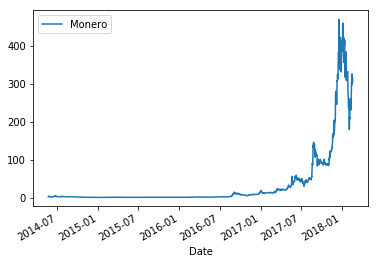

<Figure size 432x288 with 0 Axes>

In [5]:
# Plot the Close columns for df
df['Close'].plot(label='Monero', legend=True)

plt.show()  # show the plot
plt.clf()  # clear the plot space

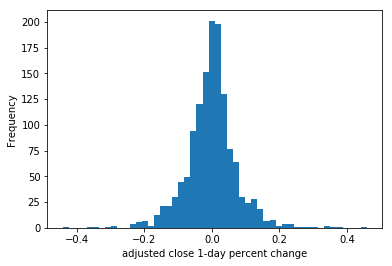

In [6]:
# Histogram of the daily price change percent of Close for Monero
df['Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

In [ ]:
# Create 5-day % changes of Close for the current day, and 5 days in the future
df['5d_future_close'] = df['Close'].shift(-5)
df['5d_close_future_pct'] = df['5d_future_close'].pct_change(5)
df['5d_close_pct'] = df['Close'].pct_change(5)



In [ ]:
# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)


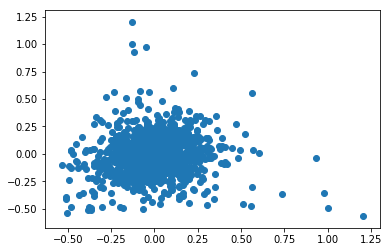

In [10]:
# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(df['5d_close_pct'], df['5d_close_future_pct'])
plt.show()



In [11]:
feature_names = ['5d_close_pct']  # a list of the feature names for later


In [12]:
# Calculate simple moving average
df['SMA(14)'] = df.Close.rolling(14).mean() / df['Close']
df['SMA(30)'] = df.Close.rolling(30).mean() / df['Close']
df['SMA(50)'] = df.Close.rolling(50).mean() / df['Close']
df['SMA(200)'] = df.Close.rolling(200).mean() / df['Close']

In [21]:
# Add moving average to the feature name list
feature_names = feature_names + ['SMA(14)', 'SMA(30)', 'SMA(50)', 'SMA(200)']



In [22]:
print(feature_names)



['5d_close_pct', 'SMA(14)', 'SMA(30)', 'SMA(50)', 'SMA(200)']


In [23]:
# Drop all na values
df = df.dropna()


In [24]:
# Create features and targets
# use feature_names for features; 5d_close_future_pct for targets
features = df[feature_names]
targets = df['5d_close_future_pct']


In [25]:
# Create DataFrame from target column and feature columns
feat_targ_df = df[['5d_close_future_pct'] + feature_names]



In [26]:
# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr.head(10))

                     5d_close_future_pct  5d_close_pct   SMA(14)   SMA(30)  \
5d_close_future_pct             1.000000      0.072232 -0.087813 -0.061836   
5d_close_pct                    0.072232      1.000000 -0.781354 -0.537084   
SMA(14)                        -0.087813     -0.781354  1.000000  0.806862   
SMA(30)                        -0.061836     -0.537084  0.806862  1.000000   
SMA(50)                        -0.047987     -0.412273  0.605182  0.889238   
SMA(200)                       -0.050659     -0.257307  0.291721  0.454702   

                      SMA(50)  SMA(200)  
5d_close_future_pct -0.047987 -0.050659  
5d_close_pct        -0.412273 -0.257307  
SMA(14)              0.605182  0.291721  
SMA(30)              0.889238  0.454702  
SMA(50)              1.000000  0.606805  
SMA(200)             0.606805  1.000000  


In [27]:
import seaborn as sns

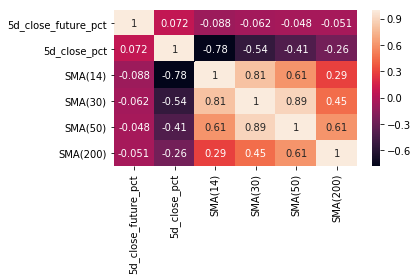

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

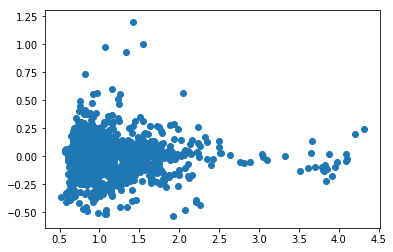

In [29]:
# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(df['SMA(50)'], df['5d_close_future_pct'])
plt.show()

In [30]:
# Import the statsmodels.api library with the alias 
import statsmodels.api as sm


In [31]:
# Add a constant to the features so we can have intercept for model. 
linear_features = sm.add_constant(features)

In [32]:
# Create a size for the training set that is 85% of the total number of samples 
# This is so we can fit our model to the train dataset, and evaluate performance on the test dataset
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(1167, 6) (991, 6) (176, 6)


In [33]:
# Create the linear model and complete the least squares fit
# Once we've fit our model, we can see which predictor variables appear to be meaningfully linearly correlated with the target, 
# as well as their magnitude of effect on the target.
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.028
Model:                             OLS   Adj. R-squared:                  0.023
Method:                  Least Squares   F-statistic:                     5.604
Date:                 Wed, 05 Dec 2018   Prob (F-statistic):           4.22e-05
Time:                         17:57:11   Log-Likelihood:                 516.26
No. Observations:                  991   AIC:                            -1021.
Df Residuals:                      985   BIC:                            -991.1
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0453      0.048    

In [34]:
# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

const           0.345279
5d_close_pct    0.488345
SMA(14)         0.750746
SMA(30)         0.040316
SMA(50)         0.098118
SMA(200)        0.119281
dtype: float64


In [35]:
# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

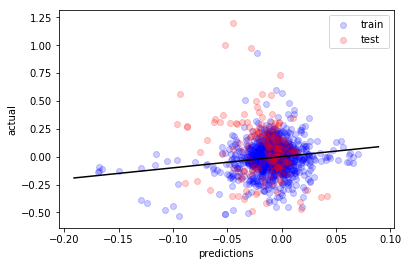

In [36]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

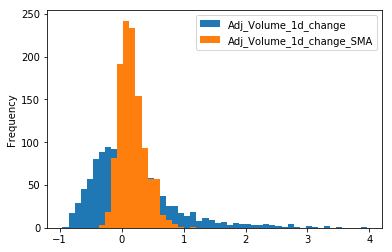

In [37]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
df['Adj_Volume_1d_change'] = df['Volume'].pct_change()
df['Adj_Volume_1d_change_SMA'] = df.Adj_Volume_1d_change.rolling(5).mean() 

# Plot histogram of volume % change data
df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()



In [38]:
from sklearn.tree import DecisionTreeRegressor


In [39]:
# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.9999999809197646
-0.7755491902464486


In [40]:
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.0960946096896146
-0.22030677074660465 

max_depth= 5
0.18119608391251418
-0.2303382268200267 

max_depth= 10
0.49090096144230894
-0.41680177830546866 



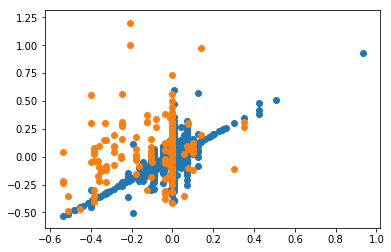

In [47]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8916452697572574
-0.4253459937860713


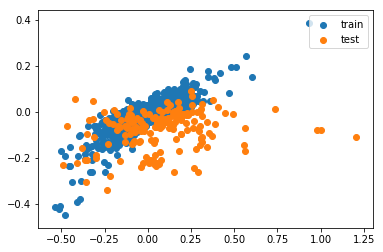

In [49]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=10, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

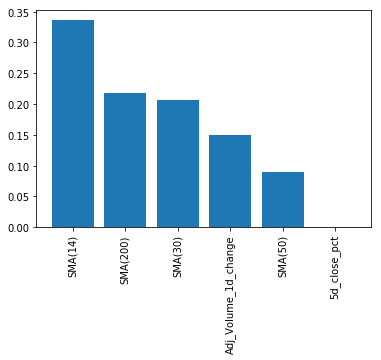

In [44]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()